# The mission

We want to apply the homologous outflow equations to a HD frame that is in the homologous outflow stage such that it can expand using said equations.

# 0. Setting everything up

We first import necessary libraries.

In [1]:
import yt
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as unit
import astropy.constants as const
%matplotlib notebook

We now define all necessary functions (homologous outflow).

In [2]:
def omega(v):
    '''
    Return $\hat{\Omega} = \dot{r}/|\dot{r}|$ for a cell grid. 
    This quantity is the unit first time derivative of the radius vector.
    
    INPUT: 
    
    --v (numpy array): (n, n, 2) shaped array containing x,y components of 
    velocity vector for an n by n grid.
    
    OUTPUT: 
    
    --omega (numpy array): (n, n, 2) vector containing x,y components of 
    velocity unit vector for an n by n grid.
    '''
    return v / np.linalg.norm(v, axis = 1)[:,None]

def s(t_sim, t):
    '''
    Return $s = c (t-t_{sim})$ in 2D. 
    This quantity is the step size the cell takes when moving at 
    speed $c$ from time $t_{sim}$ to time $t$. 
    
    INPUT: 
    
    --t_sim (float): initial time
    
    --t (float): final time
    
    OUTPUT: 
    
    --s float: magnitude of step taken in time $(t-t_{sim}})$ given by velocity $c$.
    '''

    return ( ( t - t_sim ) * const.c.cgs.value )

def r_step_c(r_i,s,omega_hat):
    '''
    Return $r = r_i + s \hat{\Omega}$ in 2D. 
    This quantity is the step size the cell takes when moving a distance
    given by s from time $t_{sim}$ to time $t$
    
    INPUT: 
    
    --r_i (numpy array)
    
    --t_sim (float): initial time
    
    --t (float): final time
    
    OUTPUT: 
    
    --s float: magnitude of step taken in time $(t-t_{sim}})$
    '''
    return ( r_i + s*omega_hat )

def dedr(e,gamma,n,r):
    return  -(8*(e**(3/4))*(4*e + 3*n))/(r*((9*n/(e**(1/4)) + 8*(e**(3/4))))) 

def dgammadr(e,gamma,n,r):
    return (8*(e**(3/4))*gamma)/(r*((9*n/(e**(1/4)) + 8*(e**(3/4)))))

def dndr(e,gamma,n,r):
    return -(6*n*(4*e + 3*n))/(e**(1/4)*r*((9*n/(e**(1/4)) + 8*(e**(3/4)))))

def homologous_outflow( gam, dens, r0, rf, ener = None, h_i = []):
    '''
    Return the solution to ODE soln. vectors (r, energy, gamma, density) 
    from r0 to rf.
    Integrates set of homologous outflow equations with initial conditions 
    
    ener (erg cm^-3 c^-2 = g cm^-3 energy density over c^2), 
    
    gam (unitless Lorentz factor), 
    
    n (g cm^-3 mass density),
    
    from r0 to rf (cm).
    
    INPUT: 
    
    --gam (numpy array): matrix containing a grid for initial Lorentz Factor
    
    --dens (numpy array): matrix containing a grid for initial mass density
    
    --r0 (numpy array): matrix containing a grid for initial radius
    
    --rf (numpy array): matrix containing a grid for final radius
    
    --ener (numpy array): matrix containing a grid for initial energy/$c^2$, default = None
    
    --h_i (numpy array): matrix containing a grid for initial specific enthalpy, default = None
    
    OUTPUT: 
    
    --r_step (numpy array): matrix containing a grid with vectors 
    containing radius discretization for solution vectors
    
    --e_arr (numpy array): matrix containing a grid with vectors 
    containing solution for energy/$c^2$ as a function of radius
    
    --gamma_arr (numpy array): matrix containing a grid with vectors 
    containing solution for Lorentz factor as a function of radius
    
    --n_arr (numpy array): matrix containing a grid with vectors 
    containing solution for mass density as a function of radius
    
    --h_arr (numpy array): matrix containing a grid with vectors 
    containing solution for specific enthalpy as a function of radius
    
    NOTES:
    
    --Even though the parameter defaults for ener and h_i are None, the function needs one or the other
    in order to retrieve the solution vectors. if ener is given, it will take it as ICs. If h_i is given,
    the function calculates energy from this and proceeds to solve the ODEs with this calculated IC.
    '''
    
    if ener == None: 
        
        ener = 3 * ( h_i - 1 ) * dens / 4 
        
        h_start = h_i
        
    if len(h_i) == 0:
        
        h_start = (ener * 4 / (dens * 3) ) + 1
    
    e_start = ener #e_tilde #e/const.c.cgs.value**2
    gamma_start = gam
    n_start = dens #/const.m_p.cgs.value

    
    
    steps = 10000

    diff = (rf - r0)/(steps-1)

    r_step = np.zeros((steps, r0.shape[0]))

    r_step[0] = r0

    for i in range(1, steps):
    
        r_step[i] = r_step[i-1] + diff

    
    
    e_arr = np.zeros(r_step.shape)       # create an array of zeros for e
    gamma_arr = np.zeros(r_step.shape)   # create an array of zeros for gamma
    n_arr = np.zeros(r_step.shape)       # create an array of zeros for n
    h_arr = np.zeros(r_step.shape)
    e_arr[0] = e_start                  # add initial value of e to array
    gamma_arr[0] = gamma_start          # add initial value of gamma to array
    n_arr[0] = n_start                  # add initial value of n to array
    h_arr[0] = h_start

    for i in range (1, r_step.shape[0]):  
        e = e_arr[i-1]
        gamma = gamma_arr[i-1]
        n = n_arr[i-1]
        r = r_step[i-1]
        Dr = r_step[i] - r_step[i-1]

        #calculate k1 for e, gamma and n
        k1_e = dedr(e,gamma,n,r)
        k1_gamma = dgammadr(e,gamma,n,r)
        k1_n = dndr(e,gamma,n,r)

        #calculate k2 for e, gamma and n
        k2_e = dedr(e+(1/2)*Dr*k1_e,gamma+(1/2)*Dr*k1_gamma,n+(1/2)*Dr*k1_n,r+(1/2)*Dr)
        k2_gamma = dgammadr(e+(1/2)*Dr*k1_e,gamma+(1/2)*Dr*k1_gamma,n+(1/2)*Dr*k1_n,r+(1/2)*Dr)
        k2_n = dndr(e+(1/2)*Dr*k1_e,gamma+(1/2)*Dr*k1_gamma,n+(1/2)*Dr*k1_n,r+(1/2)*Dr)

        #calculate k3 for e, gamma and n
        k3_e = dedr(e+(1/2)*Dr*k2_e,gamma+(1/2)*Dr*k2_gamma,n+(1/2)*Dr*k2_n,r+(1/2)*Dr)
        k3_gamma = dgammadr(e+(1/2)*Dr*k2_e,gamma+(1/2)*Dr*k2_gamma,n+(1/2)*Dr*k2_n,r+(1/2)*Dr)
        k3_n = dndr(e+(1/2)*Dr*k2_e,gamma+(1/2)*Dr*k2_gamma,n+(1/2)*Dr*k2_n,r+(1/2)*Dr)

        #calculate k4 for e, gamma and n
        k4_e = dedr(e+Dr*k3_e,gamma+Dr*k3_gamma,n+Dr*k3_n,r+Dr)
        k4_gamma = dgammadr(e+Dr*k3_e,gamma+Dr*k3_gamma,n+Dr*k3_n,r+Dr)
        k4_n = dndr(e+Dr*k3_e,gamma+Dr*k3_gamma,n+Dr*k3_n,r+Dr)

        e_arr[i] = e + (1/6)*Dr*(k1_e+2*k2_e+2*k3_e+k4_e)                   # calc. e at next radius step,add to array
        gamma_arr[i] = gamma + (1/6)*Dr*(k1_gamma+2*k2_gamma+2*k3_gamma+k4_gamma) # calc. gamma at next radius step,add to array
        n_arr[i] = n + (1/6)*Dr*(k1_n+2*k2_n+2*k3_n+k4_n)           # calc. n at next radius tep,add to array
        
        h_arr[i] = 1+ (4*e_arr[i])/(3*n_arr[i])
    
    return (r_step, e_arr, gamma_arr, n_arr, h_arr)

# 1. We now import a HD frame

We use yt to read a FLASH frame from a 16TI model. We use the final frame in our simulation, since we predict the outflow has reached a homologous state at this point in the simulation.

In [3]:
frame_flash = yt.load(
  '/Users/josearita-escalante/Documents/GRB-NASA/2nd-project/notebooks/hd-frames/16TI/FLASH/rhd_jet_big_13_hdf5_plt_cnt_3092')

yt : [WARNING  ] 2023-06-09 11:13:23,854 Guessing dimensionality as 2
yt : [WARNING  ] 2023-06-09 11:13:23,855 Extending theta dimension to 2PI + left edge.
yt : [INFO     ] 2023-06-09 11:13:23,929 Parameters: current_time              = 18558.002
yt : [INFO     ] 2023-06-09 11:13:23,931 Parameters: domain_dimensions         = [160 800   1]
yt : [INFO     ] 2023-06-09 11:13:23,932 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-06-09 11:13:23,934 Parameters: domain_right_edge         = [5.12000000e+03 2.56000000e+04 6.28318531e+00]
yt : [INFO     ] 2023-06-09 11:13:23,935 Parameters: cosmological_simulation   = 0


In [ ]:
frame_flash.field_list

In [ ]:
frame_flash.derived_field_list

# 2. Let's analyze the data

We get quantities such as the ( r , z ) components, density, energy, velocity ($v_r$, $v_z$) components.

We first need to convert all quantities containing length from code length to centimeters, by multiplying them by $10^9$. 

Let's first do position (r and z). We can use these two components to get the real radius.

In [4]:
ad = frame_flash.all_data()

z = ad['flash','z']

r = ad['flash','r']

In [5]:
r_units = r*1e9

print(r.min(),r.max())

print(r_units.min(),r_units.max())

0.00390625 cm 5119.0 cm
3906250.0 cm 5119000000000.0 cm


In [6]:
z_units = z*1e9

print(z.min(),z.max())

print(z_units.min(),z_units.max())

0.00390625 cm 25584.0 cm
3906250.0 cm 25584000000000.0 cm


In [7]:
r_comps = np.array([r_units, z_units]).T

r_mag = np.linalg.norm(r_comps, axis = 1)

We now do velocity. These velocity components are multiples of $c$. We can get the Lorentz factor from this.

In [8]:
v_f_x = ad['flash', 'velx']

v_f_y = ad['flash', 'vely']

In [9]:
print(v_f_x)

print(v_f_y)

[3.38382015e-05 3.40338884e-05 3.40608312e-05 ... 2.24541754e-01
 2.24491894e-01 2.24455371e-01] code_length/code_time
[0.99993378 0.99994081 0.99994689 ... 0.89574683 0.89625514 0.89674795] code_length/code_time


In [10]:
v_comps = np.array([v_f_x, v_f_y]).T

v_mag = np.linalg.norm(v_comps, axis = 1)

In [11]:
lor_fac = 1 / np.sqrt(1-v_mag**2)

lor_fac

array([86.89544028, 91.91340963, 97.03183313, ...,  2.60626532,
        2.61416583,  2.62194677])

Now we load energy. The flash energy (even though yt says otherwise), is already in units of erg c$^{-2}$ cm$^{-3}$.

In [12]:
ener = ad['flash','ener']

ener

unyt_array([7.57024219e+03, 8.46783203e+03, 9.43574121e+03, ...,
            7.07993889e+00, 7.12484932e+00, 7.16882181e+00], 'code_length**2/code_time**2')

Pressure is in the same units as energy and defined as $e = 3 p$. This is not what we see, not in the units or in the values themselves. 

In [13]:
pres = ad['flash','pres']

pres

unyt_array([2.08381244e-15, 2.06894574e-15, 2.15462079e-15, ...,
            1.91823705e-12, 1.93090422e-12, 1.94020581e-12], 'code_mass/(code_length*code_time**2)')

We now look at density. This has mass over volume units. 

In [14]:
dens = ad['flash','dens']

dens

unyt_array([3.85595115e-12, 4.06114725e-12, 4.27694382e-12, ...,
            1.74721834e-10, 1.74755238e-10, 1.74744136e-10], 'code_mass/code_length**3')

Let's test the h values. These do not seem quite right for energy.

In [15]:
h_ener = 1 + np.array(ener) * 4 / (3* np.array(dens))

print(h_ener.min(), h_ener.max())

7.864207906365611 2.274306036194676e+19


In [16]:
h_pres = 1 + np.array(pres) * 4 / ( np.array(dens))

print(h_pres.min(), h_pres.max())

1.0000000000281144 114.6647588100743


It seems like pressure gives us right values for enthalpy. Let's try the solver with these values.

Since there is too many elements in the matrix, I do 1000 less to adapt to my computer limitations.

In [17]:
new_r_flash = r_step_c(r_comps, s(10,100 + 10), omega(v_comps))

rf_flash = np.linalg.norm(new_r_flash, axis = 1)

r_flash, e_flash, g_flash, n_flash, h_flash = homologous_outflow( 
  lor_fac[:int(len(lor_fac)/1000)], 
  dens[:int(len(lor_fac)/1000)], 
  r_mag[:int(len(lor_fac)/1000)], 
  rf_flash[:int(len(lor_fac)/1000)], 
  h_i = h_pres[:int(len(lor_fac)/1000)]) 

We now plot the initial Lorentz factor of the HD frame before the homologous outflow profile. 

<IPython.core.display.Javascript object>


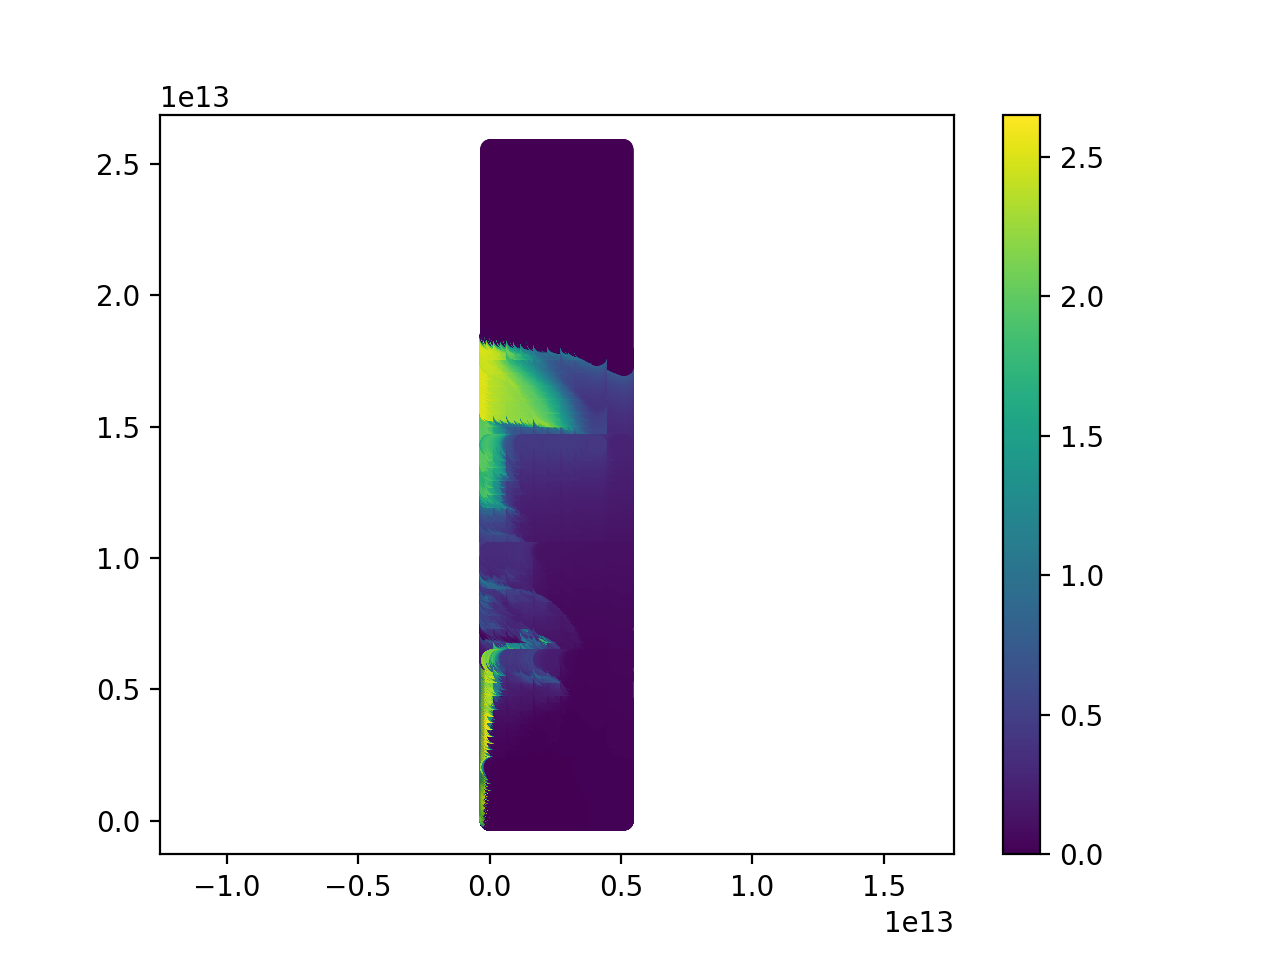

(-255945898437.5, 5374949804687.5, -1279195898437.5, 26863199804687.5)

In [18]:
fig = plt.figure()

ax = plt.gca()

mapp = ax.scatter(r_comps[:,0],r_comps[:,1], c = np.log10(lor_fac) )

cb = plt.colorbar(mappable = mapp, ax = ax )

plt.axis('equal')

We now plot the the elements that we solved the homologous outflow for.

<IPython.core.display.Javascript object>


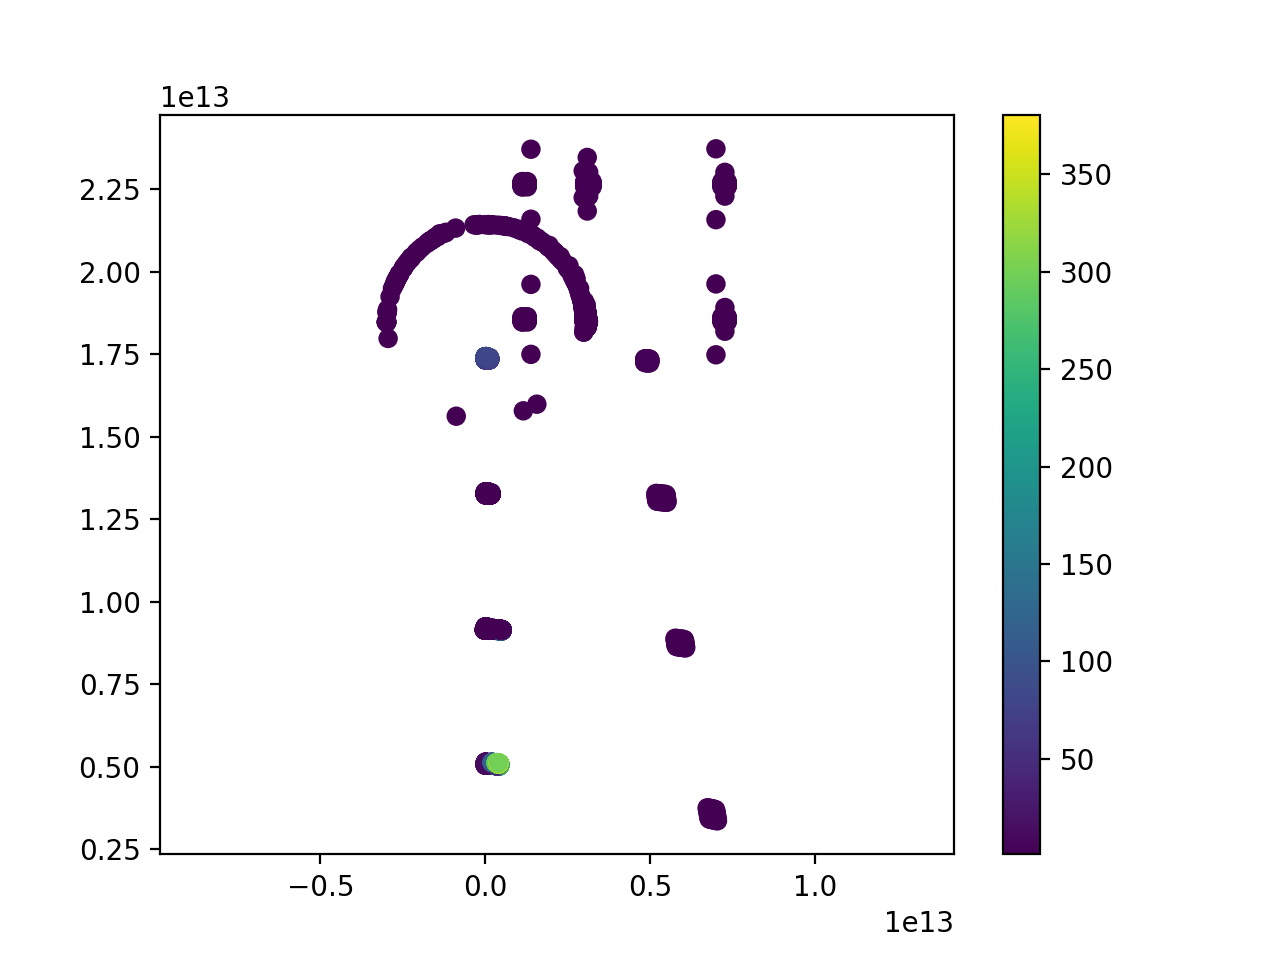

(-3512417038000.0, 7850417038000.0, 2341749214203.1646, 24748530616193.656)

In [20]:
fig = plt.figure()

ax = plt.gca()

mapp1 = ax.scatter(new_r_flash[:int(len(lor_fac)/1000),0],
  new_r_flash[:int(len(lor_fac)/1000),1],
  c = g_flash[-1] )

cb1 = plt.colorbar(mappable = mapp1, ax = ax )

plt.axis('equal')

Since the velocity vectors are not spherical, it's a different shape. Some of them have a celocity vector that leads them to have a negative r coordinate. I'm not sure what this tells us about the whole frame since it's a small subset of elements.

In [21]:
countx = 0

county = 0

for i in range(len(v_comps)):

    if v_comps[i][0]<=0:
        
        countx+=1
        
    if v_comps[i][1]<=0:
        
        county+=1

In [22]:
print(countx/len(v_comps))

print(county/len(v_comps))

print(countx, county)

0.035358188323304604
0.009156671816555537
347868 90087


About 3.5% of all elements have $\leq 0$ x-components for the velocity and about 0.4% have $\leq 0$ y-components for their velocity.

If we plot the x-components for velocity, we see that there is some negative values here.

<IPython.core.display.Javascript object>


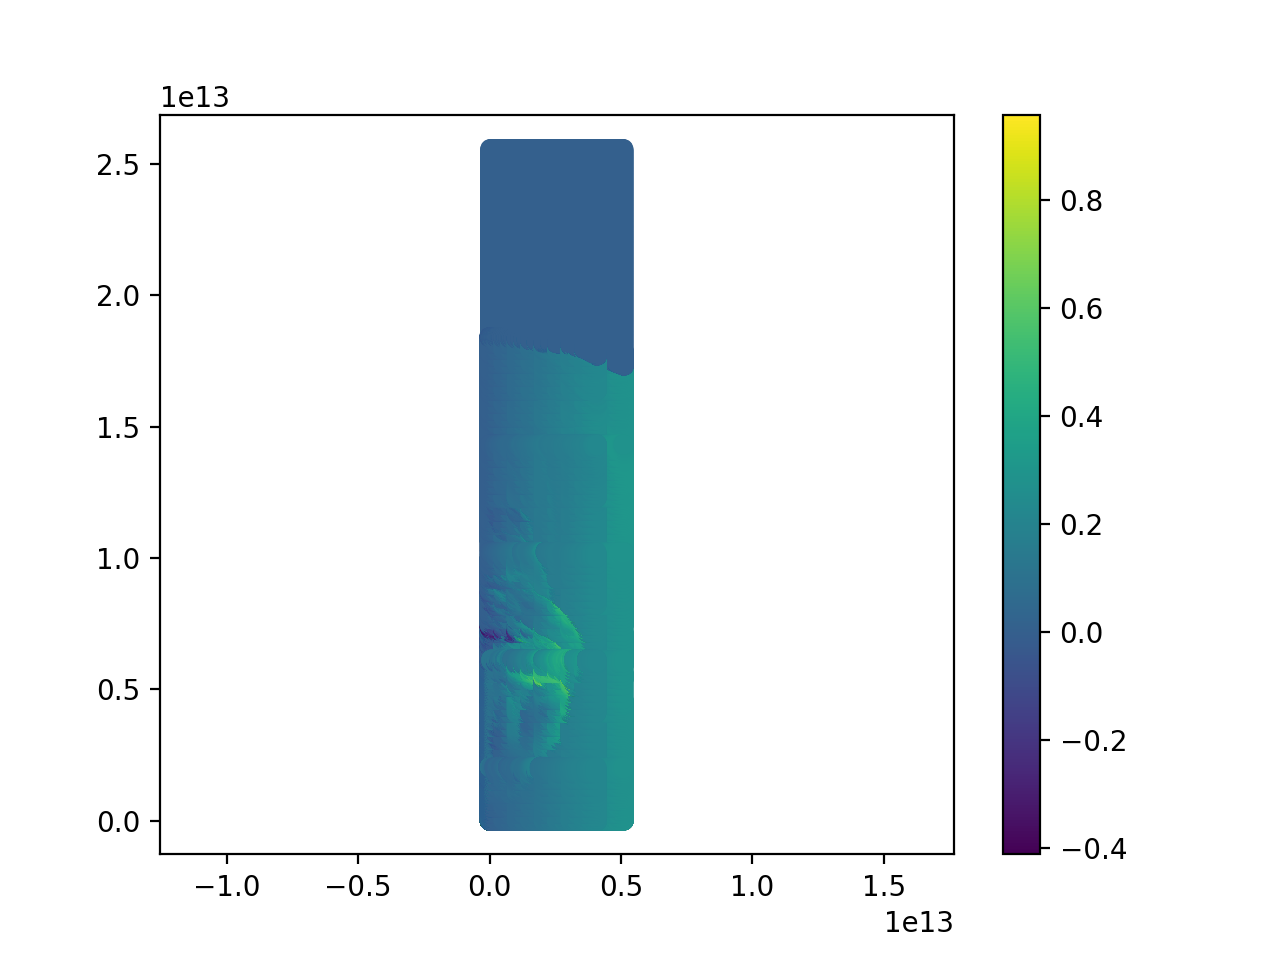

(-255945898437.5, 5374949804687.5, -1279195898437.5, 26863199804687.5)

In [23]:
fig = plt.figure()

ax = plt.gca()

mapp = ax.scatter(r_comps[:,0],r_comps[:,1], c = v_comps[:,0] )

cb = plt.colorbar(mappable = mapp, ax = ax )

plt.axis('equal')

If we plot the y-components for velocity, we see that there is some negative values here too.

<IPython.core.display.Javascript object>


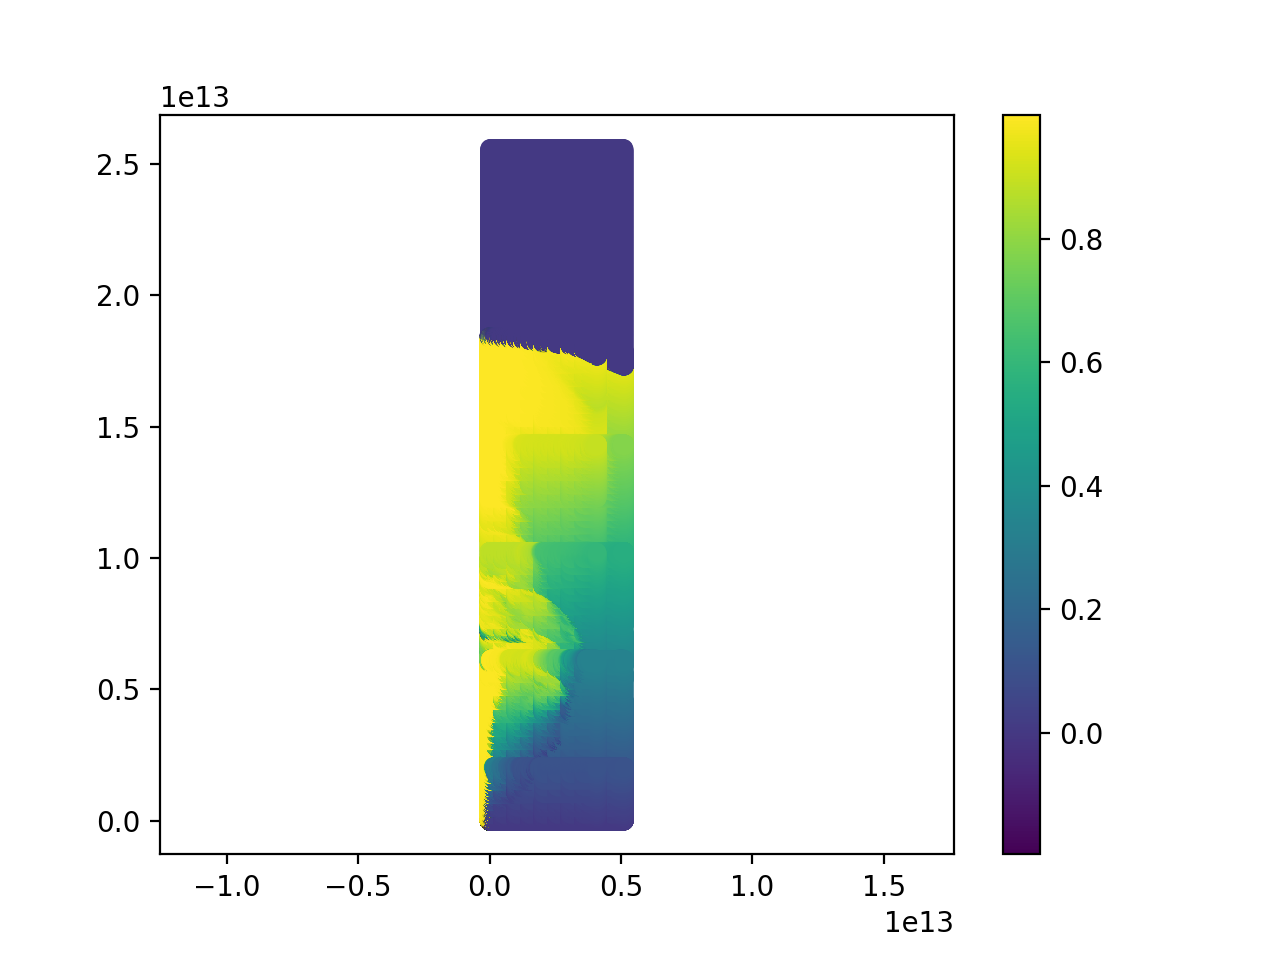

(-255945898437.5, 5374949804687.5, -1279195898437.5, 26863199804687.5)

In [24]:
fig = plt.figure()

ax = plt.gca()

mapp = ax.scatter(r_comps[:,0],r_comps[:,1], c = v_comps[:,1] )

cb = plt.colorbar(mappable = mapp, ax = ax )

plt.axis('equal')

We can see that the new cell grid position/shape is different than the original rectangle from the HD frame. 

<IPython.core.display.Javascript object>


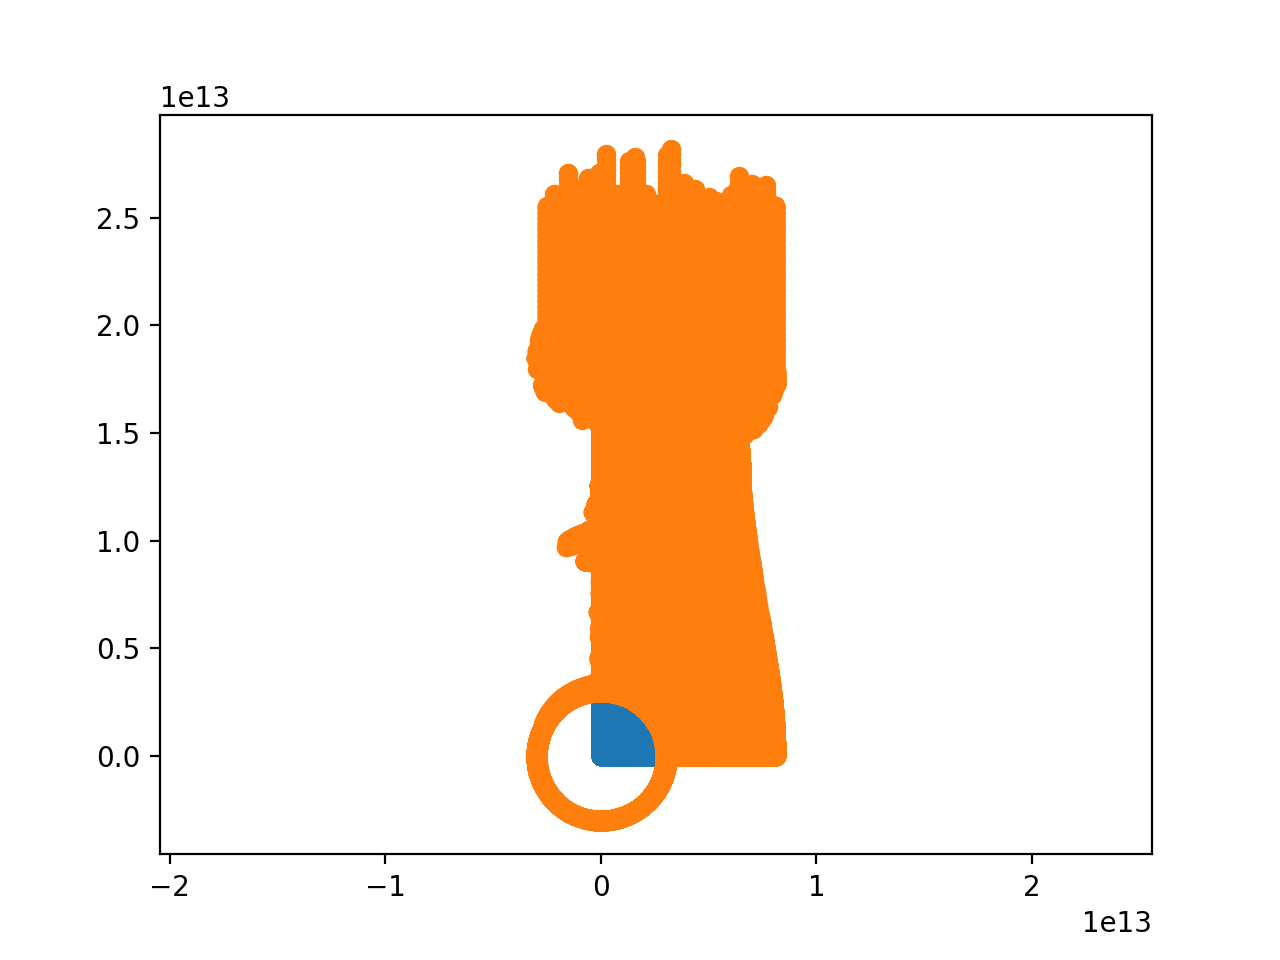

(-3553269620273.124, 8672648113346.339, -4557245836940.427, 29749606803891.664)

In [25]:
fig = plt.figure()

ax = plt.gca()

ax.scatter(r_comps[:,0],r_comps[:,1])

ax.scatter(new_r_flash[:,0],new_r_flash[:,1])

plt.axis('equal')

Let's see what happens to the cells that encompass the jet (e.g. where $1.5\times 10^{13} \leq r \leq 1.85\times 10^{13}$).

In [26]:
idx = np.where((r_mag > 1.5e13) & (r_mag < 1.85e13))[0]

r_mag_jet = r_mag[idx]

dens_jet = dens[idx]

gamma_jet = lor_fac[idx]

rf_jet = rf_flash[idx]

h_pres_jet = h_pres[idx]

In [27]:
new_r_jet = r_step_c(r_comps[idx], s(10,100 + 10), omega(v_comps[idx]))

rf_jet = np.linalg.norm(new_r_jet, axis = 1)

After scattering the cells along ther velocity vector using Ore's approximation, we get this:

<IPython.core.display.Javascript object>


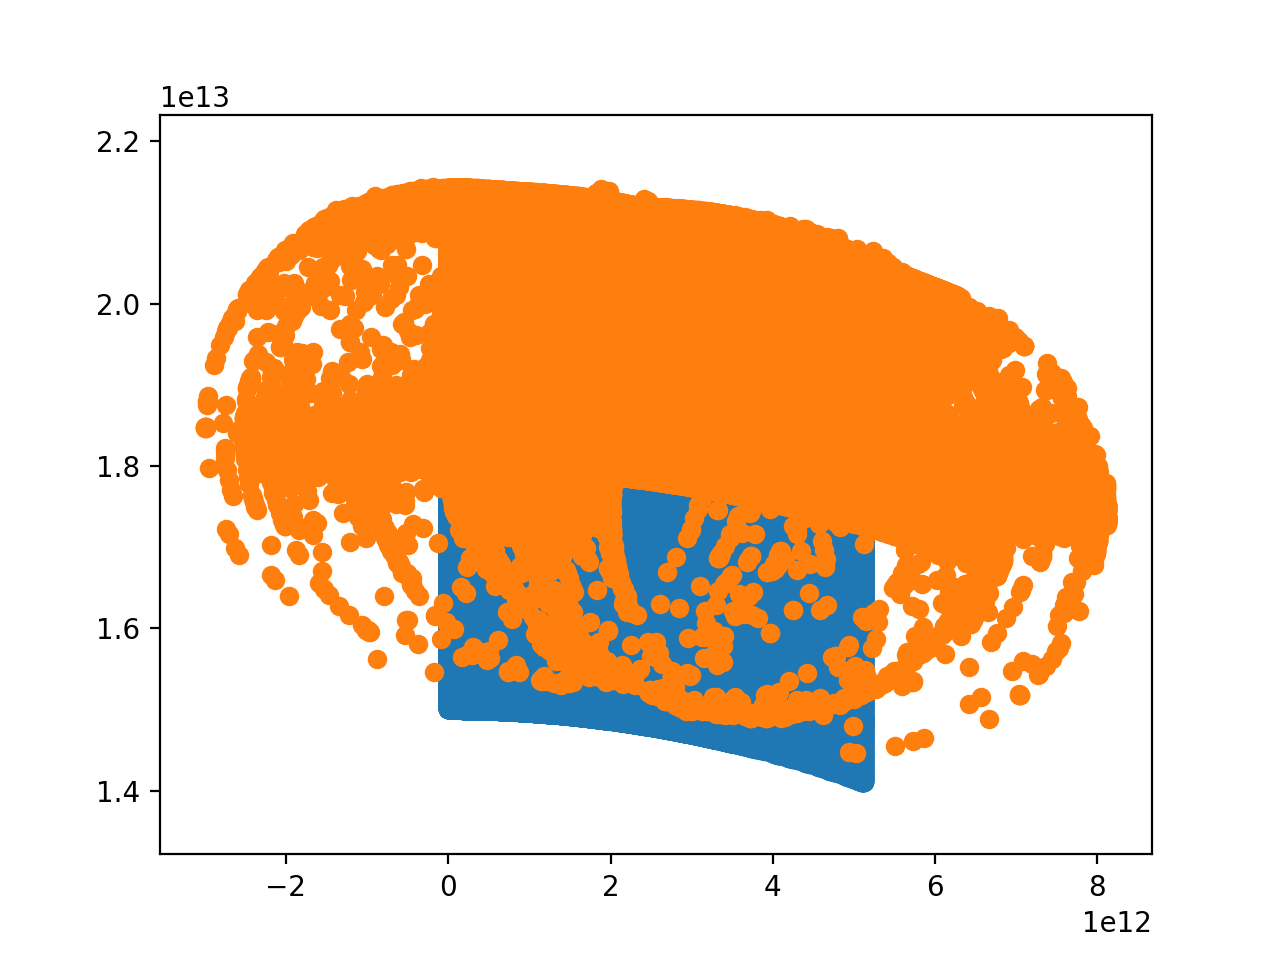

(-3551567038000.0, 8672567038000.0, 13735264569469.77, 21803444041134.84)

In [29]:
fig = plt.figure()

ax = plt.gca()

ax.scatter(r_comps[idx][:,0],r_comps[idx][:,1])

ax.scatter(new_r_jet[:,0],new_r_jet[:,1])

plt.axis('equal')

By looking at this, we can see how the original subset of cells changes shape and now has negative x-values. This leads to cell properties overlap once MCRaT accounts for the cylindrical symmetry of the HD simulation.

Looking at Ore's paper, we saw that it said 

"we advance the parameters of this element along its radial trajectory"

so it seems like the approximation assumes the cells scatter radially, similar to a spherical outflow but with the GRB jet outflow properties. 

We can compare these two cases by running the position vector array by the omega function instead of the velocity vector.

In [30]:
new_r_jet_radial = r_step_c(r_comps[idx], s(10,100 + 10), omega(r_comps[idx]))

rf_jet_radial = np.linalg.norm(new_r_jet, axis = 1)

<IPython.core.display.Javascript object>


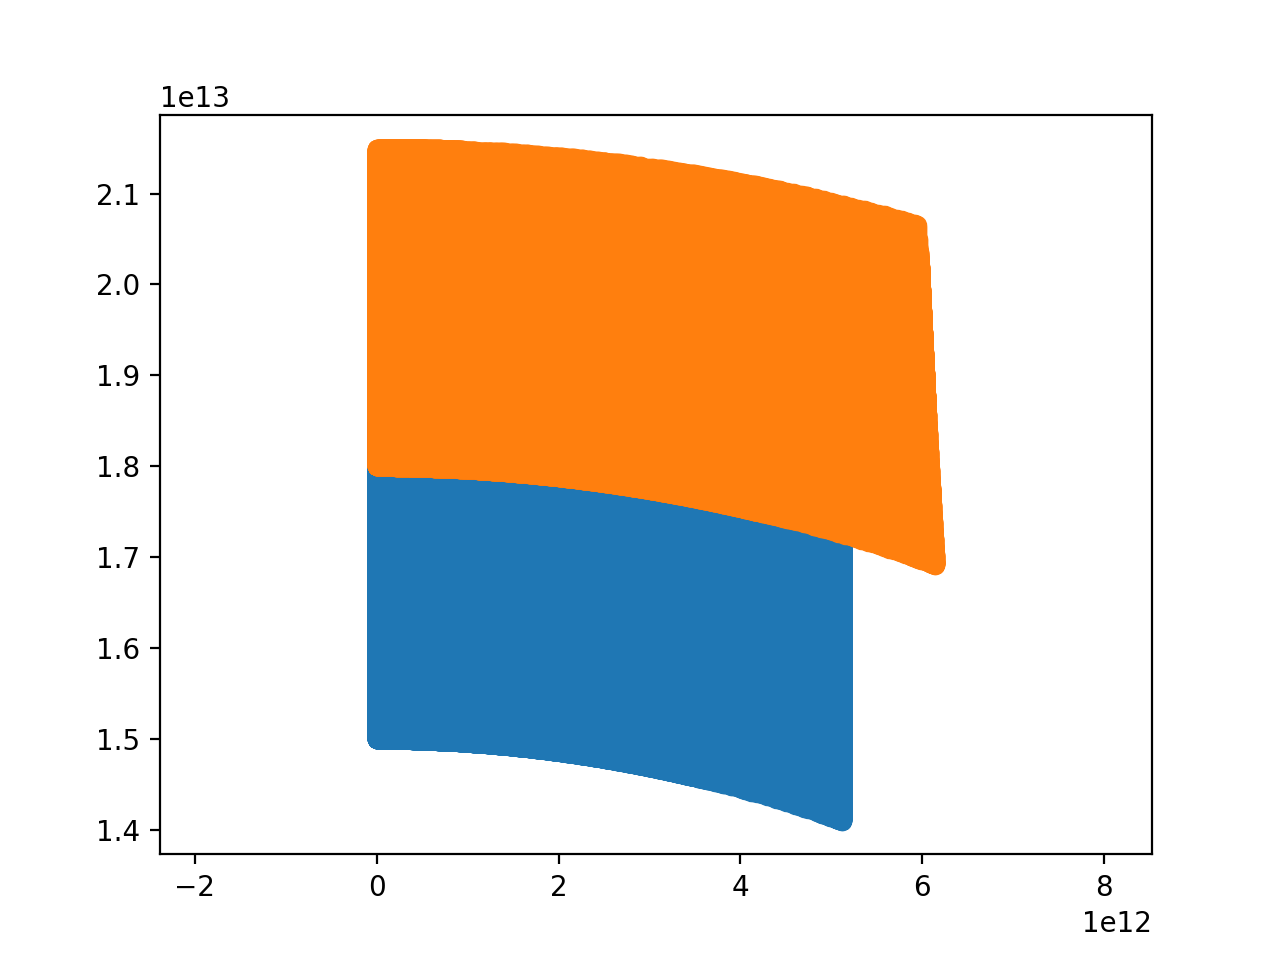

(-305987738155.46295, 6447742501264.722, 13732503771876.514, 21861420790593.2)

In [31]:
fig = plt.figure()

ax = plt.gca()

ax.scatter(r_comps[idx][:,0],r_comps[idx][:,1])

ax.scatter(new_r_jet_radial[:,0],new_r_jet_radial[:,1])

plt.axis('equal')

Would this be the right approximation for the position of the cells, or are we misunderstandin this part?